研报要点如下：

1. **因子构建**:
   - 研报中的策略主要基于滚动收益率（展期收益）计算期限结构因子，公式如下：
     $$
     TS = \left[\ln(p_t^{\text{近月}}) - \ln(p_t^{\text{主力}})\right] \times \left(\frac{365}{t_{\text{主力}} - t_{\text{近月}}}\right)
     $$
   - 其中，$p_t^{\text{近月}}$ 和 $ p_t^{\text{主力}} $分别是时间 $t$ 的近月合约和主力合约价格。
   - $t_{\text{主力}}$ 与 $t_{\text{近月}}$ 分别表示主力合约与近月合约在 $t$ 时刻距离交割日的天数
   - 主力合约与近月合约重合时采用次主力合约替代主力合约
   - 针对单个交易日只有 1 个合约交易的品种（主力合约=近月合约=次主力合约），期限结构因子值置零

3. **回测条件**:
   - 去除不稳定合约后，策略在贴水合约前20%中做多，以及在升水合约后20%中做空，使用等权重分配
   - 调仓前一交易日收盘后计算因子、判断稳定性合约，预交易标的，次日开盘价做入
   - 双边交易 0.03% 手续费，无滑点成本
   - 采用无风险收益率置零计算夏普比率
   - 去杠杆计算年化收益率（即全程去杠杆回测交易）
   - 研报回测区间：2010-1-1 至 2022-07-01
3. **期限结构因子的稳定性**:
   - 研报讨论了稳定期限结构因子的必要性。通过OLS回归去除季节性影响来测试因子的稳定性。
   - 研报稳定化后的期限结构因子（即排除季节性影响后）年化收益率几乎翻倍。

4. **回看期的优化**:
   - 通过使用回看期因子值的平均值而不是时点值（移动平均期限结构因子），策略的阿尔法生成能力有所提高。
   - 研报表现最佳的参数组合是5天的回看期和15天的再平衡期，年化收益率达到了12.61%，夏普比率为1.19。

## 数据读取预处理

读取数据库，去重合并所有数据表格，按合约 + 交易日排序，剔除收盘价为 0 的行（143行），开盘价为 0 的行（374行）添加流动性指标

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import scipy as sp
from datetime import datetime
import statsmodels.api as sm

# 加载所有CSV文件并合并为一个DataFrame
path = r'data'  # 数据集的实际路径
all_files = glob.glob(os.path.join(path, '**', '*.csv'), recursive=True)

li = []

for filename in all_files:
    df = pd.read_csv(filename, encoding='ISO-8859-1')
    df.columns = ['Market', 'Contract', 'Date', 'Open', 'High', 'Low', 'Close', 
                  'Open_Interest', 'Volume', 'Turnover',
                  'Current_Settle','Previous_Settle', 'Price_Change', 'Settle_Change']
    df['Date'] = pd.to_datetime(df['Date'])
    li.append(df)

data = pd.concat(li, axis=0, ignore_index=True)
# 去重
data = data.sort_values(by=['Contract', 'Date']).drop_duplicates()
# 去除开盘价、收盘价为0的数据
data = data[data['Close'] != 0]
data = data[data['Open'] != 0]
# 合约 + 交易日排序
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values(by=['Contract', 'Date'], inplace=True)

# 添加流动性指标
data['Volatility'] = data['Open_Interest'] + data['Volume']

start_date = data['Date'].min()
end_date = data['Date'].max()

start_date, end_date

(Timestamp('1995-04-17 00:00:00'), Timestamp('2024-06-28 00:00:00'))

假设合约最后一个交易日 +1 为交割日，添加到期日、距离到期天数字段

In [2]:
def calculate_contract_expiry(data):
    # 按合约分组，找到每个合约的最后一个交易日
    last_trade_dates = data.groupby('Contract')['Date'].max()
    # 将最后一个交易日+1天作为到期日
    contract_expiry_dates = last_trade_dates + pd.Timedelta(days=1)
    return contract_expiry_dates

# 应用到 DataFrame 中
contract_expiry_dates = calculate_contract_expiry(data)
data = data.merge(contract_expiry_dates.rename('Contract_Expiry'), on='Contract')

# 计算到期天数，使用 .loc 来赋值
data.loc[:, 'Days_to_Expiry'] = (data['Contract_Expiry'] - data['Date']).dt.days

添加合约品种列 Kinds（由合约名字提取）, 根据同品种当日最大成交量、最小到期日判断是否主力合约、近月合约、次主力合约（三个字段均为逻辑赋值）

In [3]:
# 使用正则表达式提取Contract列中的字母部分，并生成Kinds列
data['Kinds'] = data['Contract'].str.extract('([a-zA-Z]+)')

# 新增 Near_Contract 和 Main_Contract 列，Second_Main_Contract 列，并初始化为 False
data['Near_Contract'] = False
data['Main_Contract'] = False
data['Second_Main_Contract'] = False

def mark_contracts(group):
    # 标记成交量最大的合约为主力合约
    main_contract_idx = group['Volume'].idxmax()
    group.loc[main_contract_idx, 'Main_Contract'] = True
    
    # 排除主力合约，检查是否存在其他合约
    remaining_group = group.drop(index=main_contract_idx)
    if not remaining_group.empty:
        # 标记成交量第二大的合约为次主力合约
        second_main_contract_idx = remaining_group['Volume'].idxmax()
        group.loc[second_main_contract_idx, 'Second_Main_Contract'] = True
    
    # 标记到期日最早的合约为近月合约
    near_contract_idx = group['Contract_Expiry'].idxmin()
    group.loc[near_contract_idx, 'Near_Contract'] = True
    
    return group

# 按照日期和品种分组并应用标记逻辑
data = data.groupby(['Date', 'Kinds']).apply(mark_contracts)

## 季节性检验与期限结构因子计算

计算期限结构因子（展期收益）TS, 主力合约与近月合约重合时采用次主力合约替代主力合约，针对单个交易日只有 1 个合约交易的品种（主力合约=近月合约=次主力合约），期限结构因子值置零

In [4]:
# 计算期限结构因子（展期收益）

def calculate_ts(group):
    # 获取近月合约和主力合约的收盘价及到期日
    near_contract_row = group[group['Near_Contract'] == True].iloc[0]
    main_contract_row = group[group['Main_Contract'] == True].iloc[0]
    
    # 检查近月合约和主力合约是否重合
    if near_contract_row.name == main_contract_row.name:
        # 检查是否存在次主力合约
        if not group[group['Second_Main_Contract'] == True].empty:
            # 使用次主力合约替代主力合约
            main_contract_row = group[group['Second_Main_Contract'] == True].iloc[0]
        else:
            # 如果没有次主力合约，期限结构因子设为0
            ts = 0
            group['TS'] = ts
            return group
    
    p_near = near_contract_row['Close']
    p_main = main_contract_row['Close']
    
    t_near = near_contract_row['Days_to_Expiry'] 
    t_main = main_contract_row['Days_to_Expiry'] 
    
    # 计算期限结构因子 TS
    if t_main != t_near:  # 防止分母为0的情况
        ts = (np.log(p_near) - np.log(p_main)) * (365 / (t_main - t_near))
    else:
        ts = 0  # 如果没有次主力合约，期限结构因子设为0
    
    # 将计算结果存储到每个合约对应的行
    group['TS'] = ts
    return group

# 按日期和品种分组并计算TS
data = data.groupby([data.Date, data.Kinds]).apply(calculate_ts)

期限结构稳定性检验（季节性检验），新增字段'Stability', 'Beta_t', 'T_value'，Stability 为逻辑字段

In [5]:
def stability_test(group):
    # 选择流动性排名前五的合约
    top5_contracts = group.nlargest(5, 'Volatility')
    
    # 构建OLS回归模型：收盘价作为因变量，时间到期作为自变量
    X = top5_contracts['Days_to_Expiry']
    y = top5_contracts['Close']
    X = sm.add_constant(X)  # 添加常数项
    model = sm.OLS(y, X).fit()
    
    # 初始化 beta_t 和 t_value
    beta_t = np.nan
    t_value = np.nan
    
    # 获取回归系数和t值，判断模型中是否有足够的参数
    if len(model.params) > 1:
        beta_t = model.params[1]
        t_value = model.tvalues[1]
    
    # 进行显著性检验，判断期限结构是否稳定
    if abs(t_value) >= 2.0:
        stability = True  # 稳定
    else:
        stability = False  # 不稳定
    
    group['Stability'] = stability
    group['Beta_t'] = beta_t
    group['T_value'] = t_value
    
    return group

# 按日期和品种分组，并应用稳定性检验
data = data.groupby([data.Date, data.Kinds]).apply(stability_test)

计算移动平均期限结构因子，回看期 5 日

In [6]:
# 按日期和品种分组计算回看期内的因子均值
data['Avg_TS'] = data.groupby([data.Date, data.Kinds])['TS'].transform(lambda x: x.rolling(5, min_periods=1).mean())

存储预处理后数据

In [7]:
# 将处理后的数据存储为一个CSV文件
output_file_path = '含因子及稳定性数据.csv'  
data.to_csv(output_file_path, index=False)
print(f"数据已保存为 {output_file_path}")

数据已保存为 含因子及稳定性数据.csv


In [8]:
print(data.columns)

Index(['Market', 'Contract', 'Date', 'Open', 'High', 'Low', 'Close',
       'Open_Interest', 'Volume', 'Turnover', 'Current_Settle',
       'Previous_Settle', 'Price_Change', 'Settle_Change', 'Volatility',
       'Contract_Expiry', 'Days_to_Expiry', 'Kinds', 'Near_Contract',
       'Main_Contract', 'Second_Main_Contract', 'TS', 'Stability', 'Beta_t',
       'T_value', 'Avg_TS'],
      dtype='object')


# 策略回测

筛选主力合约，即每一个品种在每一天只保留一个主力合约（成交量最大的合约）

In [9]:
# 按照Date、Kinds分类，筛选出主力合约数据
trade_data = data[(data['Main_Contract'] == True)].groupby([data.Date, data.Kinds]).apply(lambda x: x)
output_file_path = '主力合约.csv'  
trade_data.to_csv(output_file_path, index=False)
print(f"数据已保存为 {output_file_path}")

数据已保存为 主力合约.csv


采用回看期5日，调仓期15日，双边交易成本0.03%，无风险利率0.02计算

In [19]:
import pandas as pd
import numpy as np
# 读取数据
trading_data = pd.read_csv('主力合约.csv')

# 按照日期从小到大排序
trading_data['Date'] = pd.to_datetime(trading_data['Date'])
trading_data = trading_data[(trading_data['Date'] >= '2010-01-01') & (trading_data['Date'] <= '2023-12-31')]
trading_data = trading_data.sort_values(by='Date')
trading_data = trading_data.reset_index(drop=True)
min_date = trading_data['Date'].min()
max_date = trading_data['Date'].max()
print(f"数据日期范围: {min_date} 到 {max_date}")

数据日期范围: 2010-01-04 00:00:00 到 2023-12-29 00:00:00


In [20]:
# 提取 Date 列的数据
trading_day = trading_data['Date']
# 按照日期从小到大排序
trading_day = trading_day.sort_values()
# 去重，得到唯一的交易日序列
trading_day = trading_day.drop_duplicates().reset_index(drop=True)

最大回撤: -43.84%
年化收益率: 2.68%
波动率: 27.32%
夏普比率: 0.02


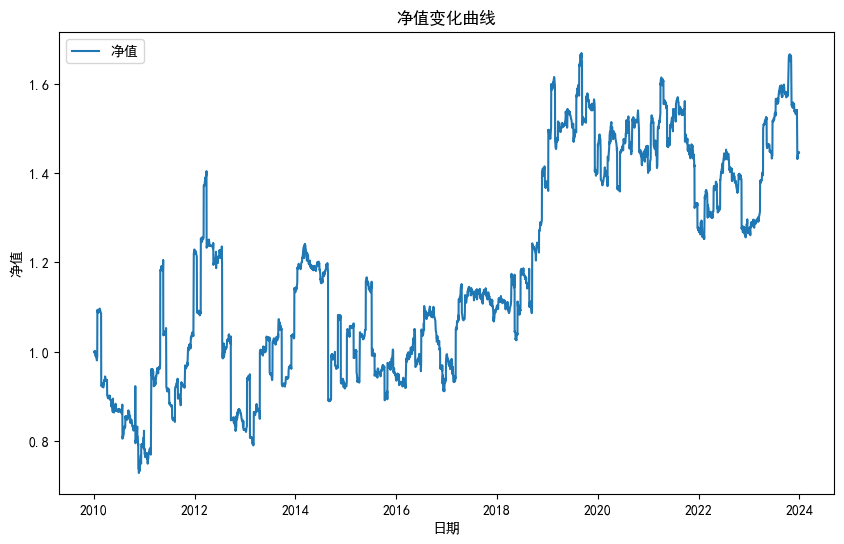

In [21]:
# 准备账本
net_value_book = pd.DataFrame(columns=['Date', 'Net_Value'])
position_record_book = pd.DataFrame(columns=['Kind', 'Direction', 'Weight', 'Open_Date', 'Open_Price', 'Close_Date', 'Close_Price'])
# 设置持仓期
rebalance_day = 15
# 回测循环框架
for index, current_date in enumerate(trading_day):
    # 第一个交易日
    if index == 0:
        today_data = trading_data[trading_data['Date'] == current_date]
        today_data = today_data[today_data['Stability'] == True]
        today_data = today_data.sort_values(by='Avg_TS') 
        # 进行long和short的选择
        sorted_data = today_data.sort_values(by='Avg_TS')
        # 计算做多和做空的数量
        num_long_short = max(int(len(sorted_data) * 0.2), 1)
        # 确定做空的资产种类（Avg_TS 大于 0 的前 20%）
        short_kinds = sorted_data[sorted_data['Avg_TS'] > 0]['Kinds'].head(num_long_short)
        # 确定做多的资产种类（Avg_TS 小于 0 的后 20%）
        long_kinds = sorted_data[sorted_data['Avg_TS'] < 0]['Kinds'].tail(num_long_short)
        # 计算当日净值
        new_record = pd.DataFrame({
        'Date': [current_date],
        'Net_Value': [1]  
        })
        net_value_book = pd.concat([net_value_book, new_record], ignore_index=True)
        continue
    
    # 第二个交易日
    if index == 1:
        open_value = 1
        today_data = trading_data[trading_data['Date'] == current_date]
        for kind in long_kinds:
            open_price = today_data[today_data['Kinds'] == kind]['Open'].iloc[0] if not today_data[today_data['Kinds'] == kind]['Open'].empty else 0
            weight = open_value / (len(long_kinds) + len(short_kinds))
            position_record_book = pd.concat([position_record_book, pd.DataFrame({
            'Kind': [kind],
            'Direction': ['Long'],
            'Weight': [weight],
            'Open_Date': [current_date],
            'Open_Price': [open_price],
            'Close_Date': [None],
            'Close_Price': [None]
            })], ignore_index=True)
            
        for kind in short_kinds:
            open_price = today_data[today_data['Kinds'] == kind]['Open'].iloc[0] if not today_data[today_data['Kinds'] == kind]['Open'].empty else 0
            weight = open_value / (len(long_kinds) + len(short_kinds))
            position_record_book = pd.concat([position_record_book, pd.DataFrame({
            'Kind': [kind],
            'Direction': ['Short'],
            'Weight': [weight],
            'Open_Date': [current_date],
            'Open_Price': [open_price],
            'Close_Date': [None],
            'Close_Price': [None]
            })], ignore_index=True)
        
        # 标记持仓天数
        holding_day = 1
        # 计算净值
        daily_net_value_change = 0
        open_positions = position_record_book[position_record_book['Close_Date'].isna()]
        for _, position in open_positions.iterrows():
            kind = position['Kind']
            direction = position['Direction']
            weight = position['Weight']
            open_price = position['Open_Price']
        
            # 获取当前品种的当天收盘价
            if not today_data[today_data['Kinds'] == kind]['Close'].empty:
                close_price = today_data[today_data['Kinds'] == kind]['Close'].iloc[0]
            else:
                close_price = 0  # 如果找不到当天的收盘价，设为0
        
            # 计算 PnL
            if direction == 'Long':
                if open_price == 0 or close_price == 0:
                    pnl = 0
                else:
                    pnl = ((close_price - open_price) / open_price) - 0.0006
            elif direction == 'Short':
                if open_price == 0 or close_price == 0:
                    pnl = 0
                else:
                    pnl = ((open_price - close_price) / open_price) - 0.0006
                    
            # 累加到当天净值变动中
            pnl=pnl+1
            daily_net_value_change += pnl * weight
        # 将当日净值写入净值账本
        net_value_book = pd.concat([net_value_book, pd.DataFrame({'Date': [current_date], 'Net_Value': [daily_net_value_change]})], ignore_index=True)
        continue
    
    if holding_day+1 == rebalance_day: # 持仓期最后一天
        today_data = trading_data[trading_data['Date'] == current_date]
        today_data = today_data[today_data['Stability'] == True]
        today_data = today_data.sort_values(by='Avg_TS') 
        # 进行long和short的选择
        sorted_data = today_data.sort_values(by='Avg_TS')
        # 计算做多和做空的数量
        num_long_short = max(int(len(sorted_data) * 0.2), 1)
        # 确定做空的资产种类（Avg_TS 大于 0 的前 20%）
        short_kinds = sorted_data[sorted_data['Avg_TS'] > 0]['Kinds'].head(num_long_short)
        # 确定做多的资产种类（Avg_TS 小于 0 的后 20%）
        long_kinds = sorted_data[sorted_data['Avg_TS'] < 0]['Kinds'].tail(num_long_short)
        # 计算净值
        daily_net_value_change = 0
        open_positions = position_record_book[position_record_book['Close_Date'].isna()]
        for _, position in open_positions.iterrows():
            kind = position['Kind']
            direction = position['Direction']
            weight = position['Weight']
            open_price = position['Open_Price']
        
            # 获取当前品种的当天收盘价
            if not today_data[today_data['Kinds'] == kind]['Close'].empty:
                close_price = today_data[today_data['Kinds'] == kind]['Close'].iloc[0]
            else:
                close_price = 0  # 如果找不到当天的收盘价，设为0
        
            # 计算 PnL
            if direction == 'Long':
                if open_price == 0 or close_price == 0:
                    pnl = 0
                else:
                    pnl = ((close_price - open_price) / open_price) - 0.0006
            elif direction == 'Short':
                if open_price == 0 or close_price == 0:
                    pnl = 0
                else:
                    pnl = ((open_price - close_price) / open_price) - 0.0006            
            # 累加到当天净值变动中
            pnl=pnl+1
            daily_net_value_change += pnl * weight
        # 将当日净值写入净值账本
        net_value_book = pd.concat([net_value_book, pd.DataFrame({'Date': [current_date], 'Net_Value': [daily_net_value_change]})], ignore_index=True)
        # 标记持仓天数
        holding_day = holding_day+1  
    elif holding_day == rebalance_day: # 新持仓周期第一天（建仓期）
        today_data = trading_data[trading_data['Date'] == current_date]
        # 计算开盘净值
        daily_net_value_change = 0
        open_positions = position_record_book[position_record_book['Close_Date'].isna()]
        for _, position in open_positions.iterrows():
            kind = position['Kind']
            direction = position['Direction']
            weight = position['Weight']
            open_price = position['Open_Price']
        
            # 获取当前品种的当天开盘价
            if not today_data[today_data['Kinds'] == kind]['Open'].empty:
                close_price = today_data[today_data['Kinds'] == kind]['Open'].iloc[0]
            else:
                close_price = 0  # 如果找不到当天的开盘价，设为0
        
            # 计算 PnL
            if direction == 'Long':
                if open_price == 0 or close_price == 0:
                    pnl = 0
                else:
                    pnl = ((close_price - open_price) / open_price) - 0.0006
            elif direction == 'Short':
                if open_price == 0 or close_price == 0:
                    pnl = 0
                else:
                    pnl = ((open_price - close_price) / open_price) - 0.0006   
            daily_net_value_change += (1+pnl) * weight
        open_value = daily_net_value_change
        # 平仓
        open_positions = position_record_book[position_record_book['Close_Date'].isna()]
        for index, row in open_positions.iterrows():
            kind = row['Kind']
            direction = row['Direction']
            open_price = row['Open_Price']
    
            # 获取当前品种的当天开盘价
            if not today_data[today_data['Kinds'] == kind]['Open'].empty:
                close_price = today_data[today_data['Kinds'] == kind]['Open'].iloc[0]
            else:
                close_price = 0  # 如果找不到当天的开盘价，设为0，用以标记该平仓不能平仓品种，对收益率、建仓无影响
        
            in_long = (kind in long_kinds.values) and (direction == 'Long')
            in_short = (kind in short_kinds.values) and (direction == 'Short')
            # 如果该品种不在 long_kinds 或 short_kinds 中，或者方向不一致，则执行平仓
            if not (in_long or in_short):
                position_record_book.loc[index, 'Close_Date'] = current_date
                position_record_book.loc[index, 'Close_Price'] = close_price
        # 开仓
        long_open_positions = open_positions[open_positions['Direction'] == 'Long']['Kind']
        long_kinds_to_process = [kind for kind in long_kinds if kind not in long_open_positions.values]
        for kind in long_kinds_to_process:
            open_price = today_data[today_data['Kinds'] == kind]['Open'].iloc[0] if not today_data[today_data['Kinds'] == kind]['Open'].empty else 0
            weight = open_value / (len(long_kinds) + len(short_kinds))
            position_record_book = pd.concat([position_record_book, pd.DataFrame({
            'Kind': [kind],
            'Direction': ['Long'],
            'Weight': [weight],
            'Open_Date': [current_date],
            'Open_Price': [open_price],
            'Close_Date': [None],
            'Close_Price': [None]
            })], ignore_index=True)
            
        short_open_positions = open_positions[open_positions['Direction'] == 'Short']['Kind']
        short_kinds_to_process = [kind for kind in short_kinds if kind not in short_open_positions.values]
        for kind in short_kinds_to_process:
            open_price = today_data[today_data['Kinds'] == kind]['Open'].iloc[0] if not today_data[today_data['Kinds'] == kind]['Open'].empty else 0
            weight = open_value / (len(long_kinds) + len(short_kinds))
            position_record_book = pd.concat([position_record_book, pd.DataFrame({
            'Kind': [kind],
            'Direction': ['Short'],
            'Weight': [weight],
            'Open_Date': [current_date],
            'Open_Price': [open_price],
            'Close_Date': [None],
            'Close_Price': [None]
            })], ignore_index=True)
        
        # 标记持仓天数
        holding_day = 1
        # 计算净值
        daily_net_value_change = 0
        open_positions = position_record_book[position_record_book['Close_Date'].isna()]
        for _, position in open_positions.iterrows():
            kind = position['Kind']
            direction = position['Direction']
            weight = position['Weight']
            open_price = position['Open_Price']
        
            # 获取当前品种的当天收盘价
            if not today_data[today_data['Kinds'] == kind]['Close'].empty:
                close_price = today_data[today_data['Kinds'] == kind]['Close'].iloc[0]
            else:
                close_price = 0  # 如果找不到当天的收盘价，设为0
        
            # 计算 PnL
            if direction == 'Long':
                if open_price == 0 or close_price == 0:
                    pnl = 0
                else:
                    pnl = ((close_price - open_price) / open_price) - 0.0006
            elif direction == 'Short':
                if open_price == 0 or close_price == 0:
                    pnl = 0
                else:
                    pnl = ((open_price - close_price) / open_price) - 0.0006
                    
            # 累加到当天净值变动中
            pnl=pnl+1
            daily_net_value_change += pnl * weight
        # 将当日净值写入净值账本
        net_value_book = pd.concat([net_value_book, pd.DataFrame({'Date': [current_date], 'Net_Value': [daily_net_value_change]})], ignore_index=True)        
        
    else: # 正常持仓期
        today_data = trading_data[trading_data['Date'] == current_date]
        # 计算净值
        daily_net_value_change = 0
        open_positions = position_record_book[position_record_book['Close_Date'].isna()]
        for _, position in open_positions.iterrows():
            kind = position['Kind']
            direction = position['Direction']
            weight = position['Weight']
            open_price = position['Open_Price']
        
            # 获取当前品种的当天收盘价
            if not today_data[today_data['Kinds'] == kind]['Close'].empty:
                close_price = today_data[today_data['Kinds'] == kind]['Close'].iloc[0]
            else:
                close_price = 0  # 如果找不到当天的收盘价，设为0
        
            # 计算 PnL
            if direction == 'Long':
                if open_price == 0 or close_price == 0:
                    pnl = 0
                else:
                    pnl = ((close_price - open_price) / open_price) - 0.0006
            elif direction == 'Short':
                if open_price == 0 or close_price == 0:
                    pnl = 0
                else:
                    pnl = ((open_price - close_price) / open_price) - 0.0006        
            # 累加到当天净值变动中
            pnl=pnl+1
            daily_net_value_change += pnl * weight
        # 将当日净值写入净值账本
        net_value_book = pd.concat([net_value_book, pd.DataFrame({'Date': [current_date], 'Net_Value': [daily_net_value_change]})], ignore_index=True)
        # 标记持仓天数
        holding_day = holding_day+1  
position_record_book.to_csv('持仓记录.csv', index=False)
net_value_book.to_csv('净值记录.CSV', index=False)

# 计算每日收益率
net_value_book['Daily_Return'] = net_value_book['Net_Value'].pct_change()
# 计算最大回撤
cum_max = net_value_book['Net_Value'].cummax()
drawdown = (net_value_book['Net_Value'] - cum_max) / cum_max
max_drawdown = drawdown.min()
# 计算年化收益率
total_return = net_value_book['Net_Value'].iloc[-1] / net_value_book['Net_Value'].iloc[0] - 1
num_years = (net_value_book['Date'].iloc[-1] - net_value_book['Date'].iloc[0]).days / 365.25
annual_return = (1 + total_return) ** (1 / num_years) - 1
# 计算波动率（年化）
volatility = net_value_book['Daily_Return'].std() * np.sqrt(252)  # 假设一年252个交易日
# 计算夏普比率
risk_free_rate = 0.02  # 假设年化无风险利率为2%
sharpe_ratio = (annual_return - risk_free_rate) / volatility

# 输出结果
print(f"最大回撤: {max_drawdown:.2%}")
print(f"年化收益率: {annual_return:.2%}")
print(f"波动率: {volatility:.2%}")
print(f"夏普比率: {sharpe_ratio:.2f}")

# 绘制净值曲线
%matplotlib inline 
import matplotlib.pyplot as plt
from matplotlib import font_manager
# 设置中文字体，解决中文显示问题
zh_font = font_manager.FontProperties(fname='C:/Windows/Fonts/simhei.ttf')  # 需要根据实际字体路径修改
plt.rcParams['font.family'] = zh_font.get_name()
plt.rcParams['axes.unicode_minus'] = False  # 解决坐标轴负号显示问题
plt.figure(figsize=(10, 6))
plt.plot(net_value_book['Date'], net_value_book['Net_Value'], label='净值')
plt.title('净值变化曲线')
plt.xlabel('日期')
plt.ylabel('净值')
plt.legend()
plt.show()